[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/annanasnas/semantic_segmentation-25/blob/main/DeepLabV2.ipynb)

In [1]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [2]:
REPO = "https://github.com/annanasnas/semantic_segmentation-25.git"
!git clone $REPO
%cd /content/semantic_segmentation-25
!pip install -q -r requirements.txt pyyaml

Cloning into 'semantic_segmentation-25'...
remote: Enumerating objects: 245, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 245 (delta 127), reused 175 (delta 63), pack-reused 0 (from 0)
Receiving objects: 100% (245/245), 3.81 MiB | 7.26 MiB/s, done.
Resolving deltas: 100% (127/127), done.
/content/semantic_segmentation-25
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Config

In [5]:
import yaml

with open("configs/deeplabv2.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

!python scripts/download_data.py

batch_size = cfg["train"]["batch_size"]
epochs = cfg["train"]["epochs"]
data_dir = cfg["data"]["root"]
learning_rate = cfg["train"]["lr"]
img_size = cfg["data"]["img_size"]
name = cfg["model"]["name"]

## DataLoaders

In [9]:
from datasets.cityscapes import CityScapes
from torch.utils.data import DataLoader
from torchvision import transforms


imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_dataset = CityScapes(
    root_dir=data_dir,
    split="train",
    image_transform=image_transforms,
    image_size=img_size
)

val_dataset = CityScapes(
    root_dir=data_dir,
    split="val",
    image_transform=image_transforms,
    image_size=img_size
)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Training

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [13]:
import torch.optim as optim
import torch.nn as nn
from models.deeplabv2.deeplabv2 import get_deeplab_v2
from torch.amp import GradScaler
from scripts.checkpoint import Checkpoint
from pathlib import Path
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_deeplab_v2()
optimizer = optim.SGD(model.optim_parameters(lr=learning_rate), momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)
scaler = GradScaler()
max_iter = len(train_dataloader) * epochs

model.to(device);


Deeplab pretraining loading...


/usr/local/lib/python3.11/dist-packages/torch/_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


In [15]:
# load checkpoint if exists
ckpt_dir = Path("/content/drive/MyDrive/semantic segmentation/checkpoints") / name
log_csv  = ckpt_dir / "log.csv"
ckpt_mgr = Checkpoint(ckpt_dir)

last_path = ckpt_dir / "last.pth"
if last_path.exists():
    ckpt = torch.load(last_path, map_location="cpu", weights_only=False)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    scaler.load_state_dict(ckpt["scaler"])
    start_epoch = ckpt["epoch"]
    iteration = ckpt["iteration"]
    best_miou   = ckpt["best_miou"]
    df_prev = pd.read_csv(log_csv)
    metrics = df_prev.to_dict("list")
else:
    start_epoch = 0
    best_miou   = 0
    iteration = 0
    metrics = {"epoch": [], "train_loss": [], "val_loss": [], "val_miou": []}


In [17]:
from scripts.train import train_deeplab

train_deeplab(start_epoch, epochs, model,
              train_dataloader, val_dataloader, device,
              optimizer, criterion, scaler,
              learning_rate, max_iter, iteration,
              best_miou, metrics, ckpt_mgr, log_csv)

# Results

In [ ]:
from scripts.utils import create_final_table
from scripts.train import validate
import warnings, logging

logging.getLogger("fvcore.nn.jit_analysis").setLevel(logging.ERROR)

model = get_deeplab_v2()
df = create_final_table(model, name, device, (img_size, img_size*2), epochs)

best_path = ckpt_dir / "best.pth"
best_model = torch.load(best_path, map_location=device)
model.load_state_dict(best_model["model"])
df["mIoU (%)"] = validate(model, val_dataloader, device) * 100
print(df.to_markdown(index=False))

| Model                 | Latency                                                                | FLOPs   | Params   |   mIoU (%) |
|:----------------------|:-----------------------------------------------------------------------|:--------|:---------|-----------:|
| deeplabv2 - 50 epochs | Mean latency: 0.24 +/- 0.03, Mean FPS: 4.24 +/- 2.37 frames per second | 376.1 G | 43.9 M   |    59.7789 |


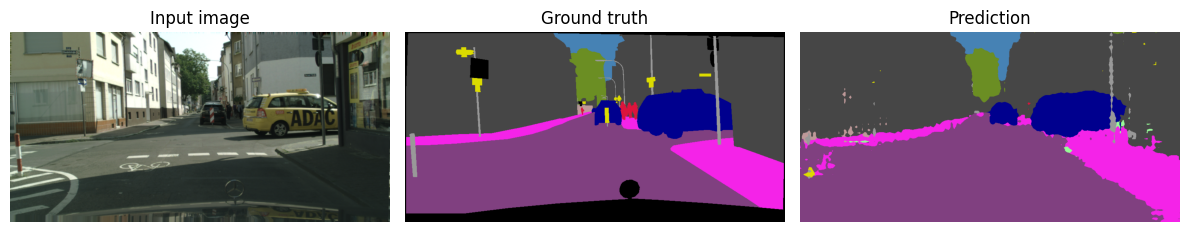

In [18]:
from scripts.utils import visualize_sample

visualize_sample(val_dataloader, model)